### ML PROJECT DESCRIPTION:
TITLE: One-shot Image Verification using deep learning
In the one-shot learning setting, we must correctly make predictions given only a single training example of each new class. One extremely successful approach entails using Deep Siamese Networks [1]. The challenge is as follows:
1: Implement  the Deep Siamese Network architecture using any of the open-source deep learning platforms in Python (Preferably, PyTorch, Tensorflow or Keras)
2: Perform image verification using just one reference image. You may use the Olivetti faces dataset [2]
3: Tabulate the error performance 
 (Bonus points) Think of interesting ways to augment the training data that might result in lowering of the mis-classification error and/or add robustness to the solution proposed..

References:
[1] https://www.cs.cmu.edu/~rsalakhu/papers/oneshot1.pdf
[2] http://scikit-learn.org/stable/datasets/olivetti_faces.html

Notes:
1: You are perfectly entitled to use other approaches of one-shot learning as long as you have sound justification(s)
2: You are perfectly entitled to reuse any openly available code/dataset as long as it is clearly cited.
3: Which error metrics to choose? What plots to show? How many folds of cross-validation?
You choose. You will be asked to defend your choices during the presentation.
The goal of this project is to gauge these qualities:
1: Ability to quickly prototype a top tier publication
2: Ability to think of out-of-the-box and seek free lunches (Dataset augmentation tasks)
3: Ability to write clean and well commented publication quality code.
4: Error-metric visualization tactics and the ability to communicate the results clearly and legibly.


References: 
[1]https://github.com/Kadenze/siamese_net
[2]http://scikitlearn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces

In [1]:
import os
from time import time 
import pickle
import numpy as np
import siamese_net as sn
import lasagne
import theano
import theano.tensor as T
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_olivetti_faces
import logging
from numpy.random import RandomState
from sklearn.cluster import MiniBatchKMeans
from sklearn import decomposition
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')
n_row, n_col = 2, 3
n_components = n_row * n_col
image_shape = (64, 64)
rng = RandomState(0)



/Users/koyuki.nakamori/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#load faces data 
dataset = fetch_olivetti_faces(shuffle=True, random_state=rng)
faces = dataset.data

n_samples, n_features = faces.shape

# global centering
faces_centered = faces - faces.mean(axis=0)

# local centering
faces_centered -= faces_centered.mean(axis=1).reshape(n_samples, -1)

print("Dataset consists of %d faces" % n_samples)


Dataset consists of 400 faces


In [3]:
def plot_gallery(title, images, n_col=n_col, n_row=n_row):
    plt.figure(figsize=(2. * n_col, 2.26 * n_row))
    plt.suptitle(title, size=16)
    for i, comp in enumerate(images):
        plt.subplot(n_row, n_col, i + 1)
        vmax = max(comp.max(), -comp.min())
        plt.imshow(comp.reshape(image_shape), cmap=plt.cm.gray,
                   interpolation='nearest',
                   vmin=-vmax, vmax=vmax)
        plt.xticks(())
        plt.yticks(())
    plt.subplots_adjust(0.01, 0.05, 0.99, 0.93, 0.04, 0.)
    


In [4]:
estimators = [
    ('Eigenfaces - PCA using randomized SVD',
     decomposition.PCA(n_components=n_components, svd_solver='randomized',
                       whiten=True),
     True),

    ('Non-negative components - NMF',
     decomposition.NMF(n_components=n_components, init='nndsvda', tol=5e-3),
     False),

    ('Independent components - FastICA',
     decomposition.FastICA(n_components=n_components, whiten=True),
     True),

    ('Sparse comp. - MiniBatchSparsePCA',
     decomposition.MiniBatchSparsePCA(n_components=n_components, alpha=0.8,
                                      n_iter=100, batch_size=3,
                                      random_state=rng),
     True),

    ('MiniBatchDictionaryLearning',
        decomposition.MiniBatchDictionaryLearning(n_components=15, alpha=0.1,
                                                  n_iter=50, batch_size=3,
                                                  random_state=rng),
     True),

    ('Cluster centers - MiniBatchKMeans',
        MiniBatchKMeans(n_clusters=n_components, tol=1e-3, batch_size=20,
                        max_iter=50, random_state=rng),
     True),

    ('Factor Analysis components - FA',
     decomposition.FactorAnalysis(n_components=n_components, max_iter=2),
     True),
]


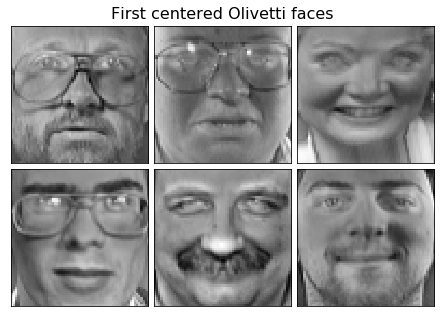

In [5]:
plot_gallery("First centered Olivetti faces", faces_centered[:n_components])

Extracting the top 6 Eigenfaces - PCA using randomized SVD...
done in 0.174s
Extracting the top 6 Non-negative components - NMF...
done in 0.928s
Extracting the top 6 Independent components - FastICA...


/Users/koyuki.nakamori/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


done in 0.277s
Extracting the top 6 Sparse comp. - MiniBatchSparsePCA...
done in 1.016s
Extracting the top 6 MiniBatchDictionaryLearning...
done in 0.752s
Extracting the top 6 Cluster centers - MiniBatchKMeans...
done in 0.084s
Extracting the top 6 Factor Analysis components - FA...
done in 0.110s


/Users/koyuki.nakamori/anaconda/lib/python2.7/site-packages/sklearn/decomposition/factor_analysis.py:224: ConvergenceWarning: FactorAnalysis did not converge. You might want to increase the number of iterations.
  ConvergenceWarning)


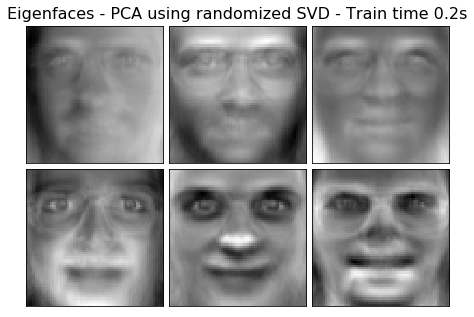

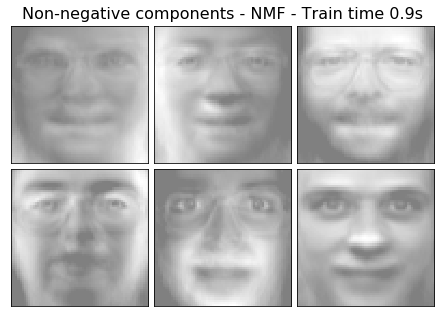

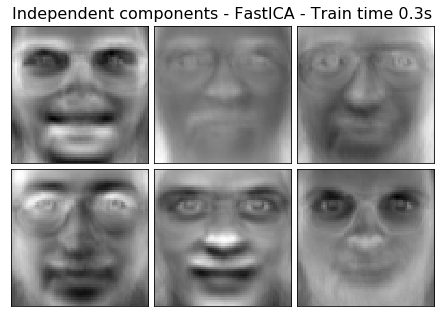

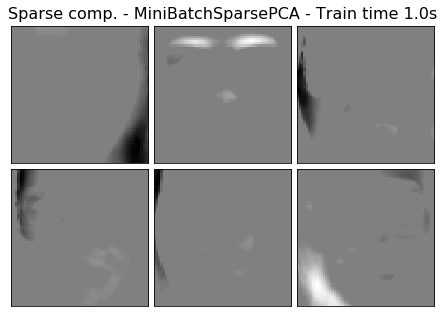

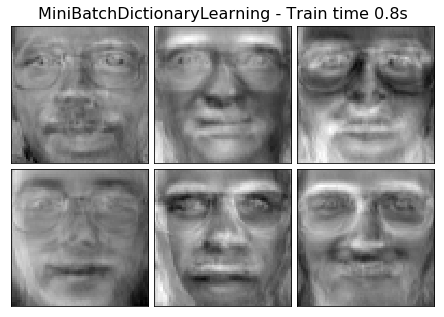

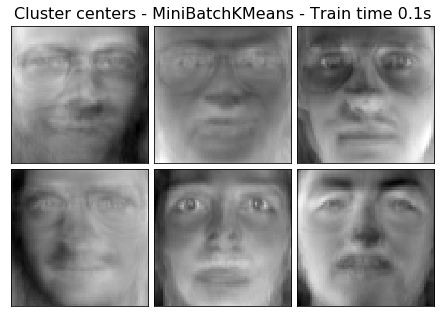

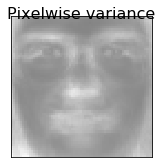

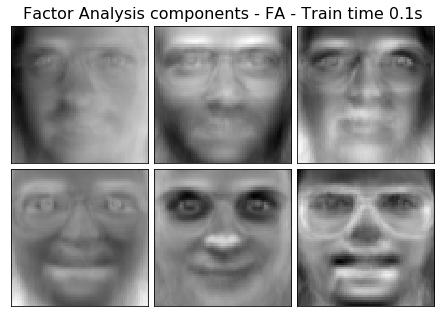

In [6]:
for name, estimator, center in estimators:
    print("Extracting the top %d %s..." % (n_components, name))
    t0 = time()
    data = faces
    if center:
        data = faces_centered
    estimator.fit(data)
    train_time = (time() - t0)
    print("done in %0.3fs" % train_time)
    if hasattr(estimator, 'cluster_centers_'):
        components_ = estimator.cluster_centers_
    else:
        components_ = estimator.components_
    if (hasattr(estimator, 'noise_variance_') and
            estimator.noise_variance_.shape != ()):
        plot_gallery("Pixelwise variance",
                     estimator.noise_variance_.reshape(1, -1), n_col=1,
                     n_row=1)
    plot_gallery('%s - Train time %.1fs' % (name, train_time),
                 components_[:n_components])

plt.show()

In [7]:
net = sn.SiameseNetPredictor(filename='model.pkl',
                             images=faces)

ValueError: unsupported pickle protocol: 3

In [10]:
###Convolutional Siamese Net can be used to augument the training data by lowering of the mis-classification error and/or add robustness to the solution proposed.. 